In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib.animation import PillowWriter, FFMpegWriter
import matplotlib.animation
from tqdm import tqdm
from time import time

plt.rcParams["font.size"] = 16

In [2]:
make_and_save_gif = False
save_plots = False

In [3]:
PREM = pd.read_csv("PREM_1s.csv",header=None, names = ["radius","depth","density","Vpv","Vph",
                                                       "Vsv","Vsh","eta","Q-mu", "Q-kappa"])
radius = PREM["radius"].values
density = PREM["density"].values
earth_radius = radius[0]

# Find the kinks
kink_rad = [ radius[i] for i in range(len(density)-1) if abs(density[i]-density[i+1]) > 0.5]

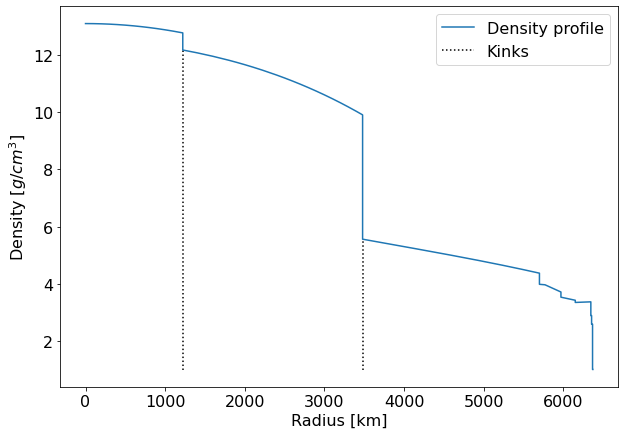

In [4]:
fig= plt.figure(figsize=(10,7))
plt.plot(radius, density)
for rad in kink_rad:
    plt.vlines(rad, min(density), density[radius==rad], ls = 'dotted')
plt.xlabel("Radius [km]")
plt.ylabel("Density [$g/cm^3$]")
plt.legend(["Density profile", "Kinks"])
plt.show()

if save_plots:
    fig.savefig("density_profile.png", dpi=300)

In [20]:
def plot_circle(ax, r, resolution = 1000, ls='dotted'):
    x = np.linspace(-r, r, resolution)
    y = [ np.sqrt(r**2-x**2), -np.sqrt(r**2-x**2) ]
    for i in range(2): 
        ax.plot(x, y[i], ls=ls, color='k')

def find_source(distance):
    if distance<=2*earth_radius:
        theta = 2*np.arcsin(distance/2/earth_radius)
        x = earth_radius*np.sin(theta)
        y = earth_radius*np.cos(theta)
        return x, y, [0, x], [earth_radius, y]
    else:
        print("Distance cannot be longer than the diameter of the earth")

def find_density_change(distance, resolution=1000, interpolation_kind='nearest'):
    if distance<=2*earth_radius:
        inter_density = interp1d(radius, density, kind=interpolation_kind)
        
        # Find cosine of the angle to the source
        cos_theta = distance/2/earth_radius
        
        # Get the vector of distances from detector to source
        distance_lin = np.linspace(0, distance, resolution)
        
        # Find the radii change for given distances
        r_lin = np.sqrt( distance_lin**2 + earth_radius**2 - 2*distance_lin*earth_radius*cos_theta )
        r_lin[r_lin>earth_radius] = earth_radius
        
        # Find the density changes for the given radii
        density_lin = inter_density(r_lin)
        
        return distance_lin, density_lin, r_lin
    else:
        print("Distance cannot be longer than the diameter of the earth")

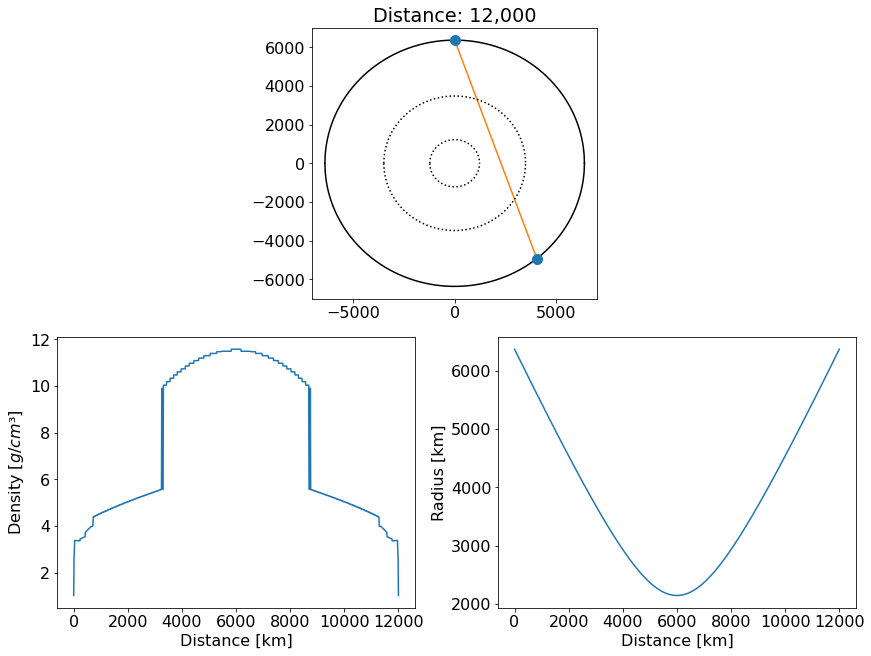

In [21]:
Distance = 12000

# Plotting!
fig = plt.figure(figsize=(12,9), constrained_layout=True)
gs = fig.add_gridspec(2,12)

# Make the circle plot
ax1 = fig.add_subplot(gs[0,3:-4])
ax1.set_title(f"Distance: {Distance:,.0f}")
plot_circle(ax1, earth_radius, ls='solid')
for rad in kink_rad[1:]:
    plot_circle(ax1, rad)
ax1.plot(0, earth_radius, '.', ms=20, color="C0")
x1, y1, x2, y2 = find_source(Distance)
ax1.plot(x1, y1, '.', ms=20, color="C0")
ax1.plot(x2, y2, color="C1", zorder=1)

# Make the density change plot
ax2 = fig.add_subplot(gs[1,:6])
distance_lin, density_lin, r_lin =  find_density_change(Distance)
ax2.plot(distance_lin, density_lin)
ax2.set_xlabel("Distance [km]")
ax2.set_ylabel("Density [$g/cm³$]")

# Make the radius change plot
ax3 = fig.add_subplot(gs[1,6:])
ax3.plot(distance_lin, r_lin)
ax3.set_xlabel("Distance [km]")
ax3.set_ylabel("Radius [km]")
plt.show()

if save_plots:
    fig.savefig(f"density_change_d_{Distance}.png", dpi=300)

In [24]:
if make_and_save_gif:
    x1, y1, x2, y2 = [], [], [], []
    distance_lin, density_lin, r_lin = [], [], []
    
    angles = np.linspace(0.01,np.pi,1000)
    
    #distances = np.round(np.sqrt( 2*earth_radius**2*(1-np.cos(angles)) ))
    distances = np.sqrt( 2*earth_radius**2*(1-np.cos(angles)) )
    for i in tqdm(range(len(distances))):
        # Calculate variables for different distances
        var = find_source(distances[i])
        x1.append(var[0])
        y1.append(var[1])
        x2.append(var[2])
        y2.append(var[3])
        
        var1 = find_density_change(distances[i])
        distance_lin.append(var1[0])
        density_lin.append(var1[1])
        r_lin.append(var1[2])

100%|██████████| 1000/1000 [00:00<00:00, 4945.63it/s]


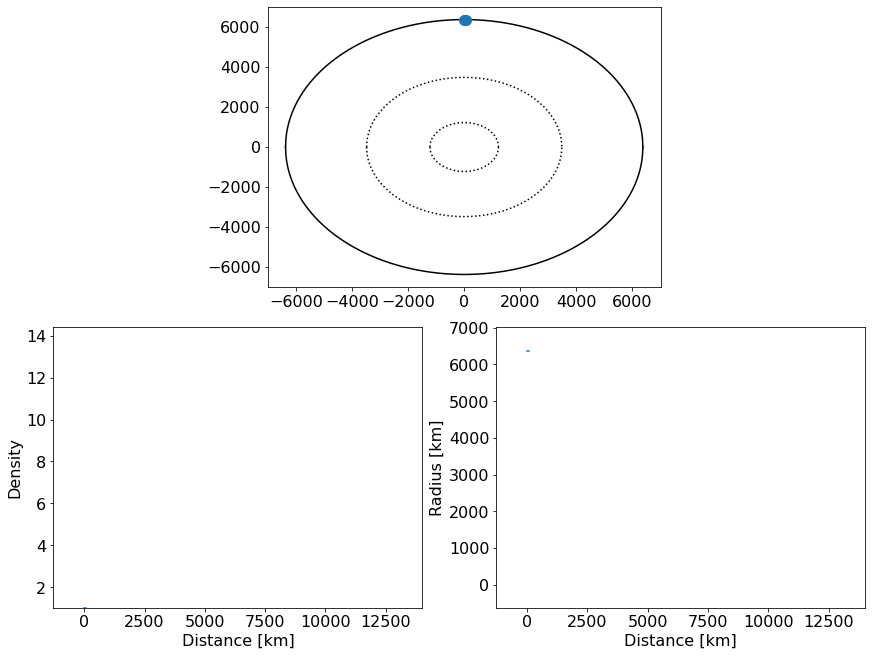

In [25]:
if make_and_save_gif:
    fig = plt.figure(figsize=(12,9), constrained_layout=True)
    gs = fig.add_gridspec(2,12)

    # Make the constant background
    ax1 = fig.add_subplot(gs[0,3:-4])
    ax2 = fig.add_subplot(gs[1,:6])
    ax3 = fig.add_subplot(gs[1,6:])
    plot_circle(ax1, radius[0], ls='solid')
    for rad in kink_rad[1:]:
        plot_circle(ax1, rad)
    ax1.plot(0, earth_radius, '.', ms=20, color="C0")
    
    ax2.set_xlabel("Distance [km]")
    ax2.set_ylabel("Density")
    ax3.set_xlabel("Distance [km]")
    ax3.set_ylabel("Radius [km]")
    
    # Make starting positions:
    l = []
    # Circle plot
    l.append(ax1.plot(x1[0], y1[0], '.', ms=20, color="C0")[0])
    l.append(ax1.plot(x2[0], y2[0], color="C1", zorder=1)[0])
    
    # Density Change
    l.append(ax2.plot(distance_lin[0], density_lin[0])[0])
    ax2.set_xlim([min(distance_lin[-1]-0.1*max(distance_lin[-1])), max(distance_lin[-1])*1.1])
    ax2.set_ylim([min(density_lin[-1]), max(density_lin[-1])*1.1])
    
    # Radius change
    l.append(ax3.plot(distance_lin[0], r_lin[0])[0])
    ax3.set_xlim([min(distance_lin[-1]-0.1*max(distance_lin[-1])), max(distance_lin[-1])*1.1])
    ax3.set_ylim([min(r_lin[-1])-0.1*max(r_lin[-1]), max(r_lin[-1])*1.1])
    
    def animate(i):
        l[0].set_data(x1[i], y1[i])
        l[1].set_data(x2[i], y2[i])
        l[2].set_data(distance_lin[i], density_lin[i])
        l[3].set_data(distance_lin[i], r_lin[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(x1), interval=50)
    writer = PillowWriter(fps=50)
    ani.save("demo.gif", writer=writer)